In [18]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [19]:
DATASET_PATH = '/Users/msughter/Downloads/dataf/speakers'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['30 and above male' '9 - 19 male' '20 -29 female' '9 - 19 female '
 '20 - 29 male ' '30 and above female']


In [33]:
# function to load the data and delete bad wav files
# Define a function to load and preprocess audio data
def load_and_preprocess_audio(file_path):
    try:
        audio_binary = tf.io.read_file(rf'{file_path}')
        audio_waveform = tf.audio.decode_wav(audio_binary).audio
        
    except tf.errors.InvalidArgumentError:
        # delete problematic files
        print(f'PROBLEMATIC FILE ENCOUNTERED AT {file_path}')
        os.remove(file_path)
# function to loop through everything
def data_loop():
    for folder_path in commands:
        for file_path in os.listdir(os.path.join(DATASET_PATH,folder_path)):
            new_path = os.path.join(DATASET_PATH,folder_path)
            load_and_preprocess_audio(file_path=os.path.join(new_path,file_path))

In [34]:
data_loop()

2023-09-23 09:09:05.744469: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found 


PROBLEMATIC FILE ENCOUNTERED AT /Users/msughter/Downloads/dataf/speakers/30 and above male/.DS_Store
PROBLEMATIC FILE ENCOUNTERED AT /Users/msughter/Downloads/dataf/speakers/9 - 19 female /hwakwara.wav


2023-09-23 09:09:09.158711: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found Pref


PROBLEMATIC FILE ENCOUNTERED AT /Users/msughter/Downloads/dataf/speakers/9 - 19 female /hapukwuoro.wav


2023-09-23 09:09:09.519967: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found View


In [35]:

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6135 files belonging to 6 classes.
Using 4295 files for training.
Using 1840 files for validation.

label names: ['20 - 29 male ' '20 -29 female' '30 and above female' '30 and above male'
 '9 - 19 female ' '9 - 19 male']


In [36]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [37]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


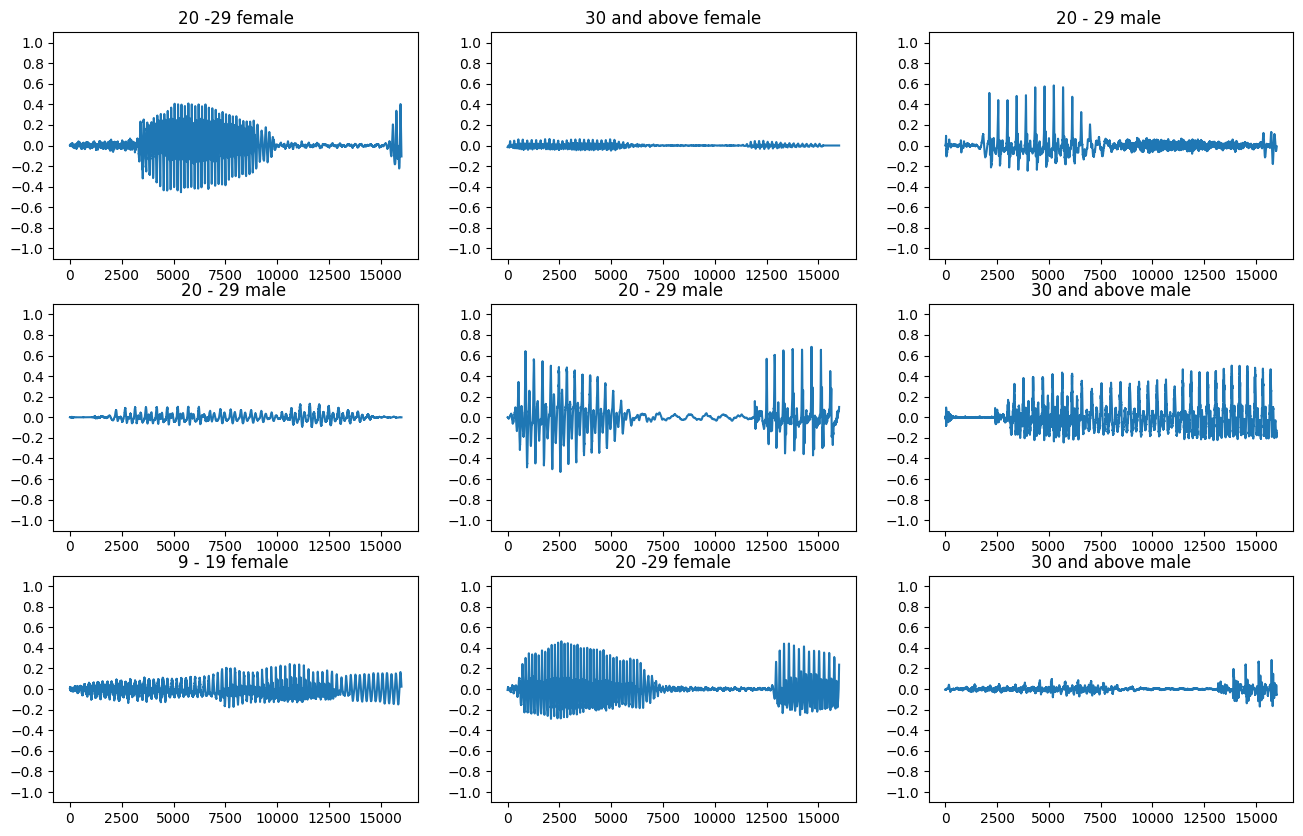

In [38]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [39]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=48000))

Label: 20 -29 female
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: 30 and above female
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: 20 - 29 male 
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


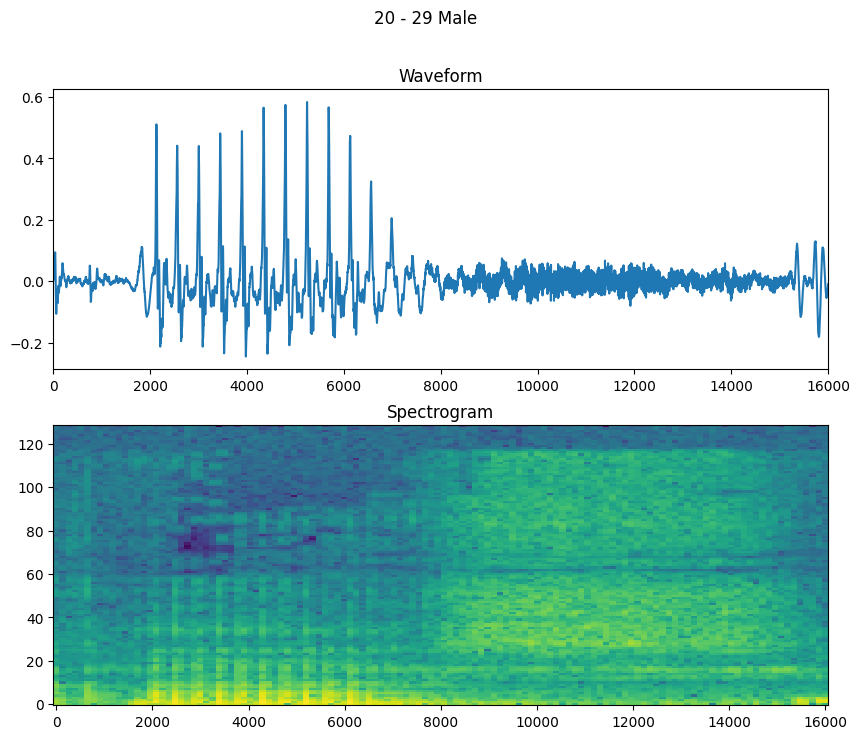

In [40]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [41]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

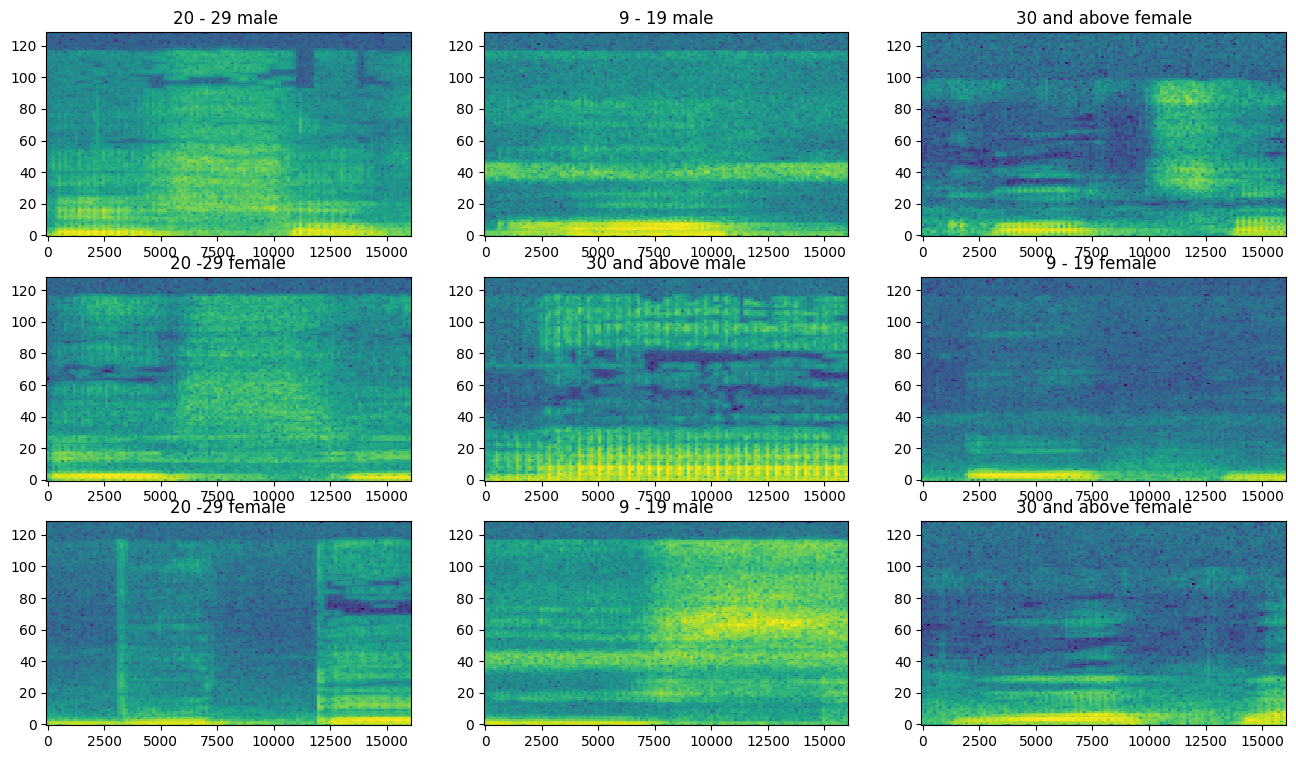

In [42]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [43]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(48, 48),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 48, 48, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 48, 48, 1)        3         
 ion)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)       

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2023-09-23 09:10:11.477402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-23 09:10:11.477429: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-09-23 09:10:11.516985: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

68/68 [==============================] - 23s 301ms/step - loss: 0.9654 - accuracy: 0.6231 - val_loss: 0.4692 - val_accuracy: 0.8527
Epoch 2/10
68/68 [==============================] - 19s 286ms/step - loss: 0.4093 - accuracy: 0.8489 - val_loss: 0.3174 - val_accuracy: 0.9018
Epoch 3/10
68/68 [==============================] - 20s 288ms/step - loss: 0.2932 - accuracy: 0.8943 - val_loss: 0.2515 - val_accuracy: 0.9062
Epoch 4/10
68/68 [==============================] - 20s 294ms/step - loss: 0.2349 - accuracy: 0.9206 - val_loss: 0.2111 - val_accuracy: 0.9174
Epoch 5/10
68/68 [==============================] - 20s 291ms/step - loss: 0.1940 - accuracy: 0.9325 - val_loss: 0.2298 - val_accuracy: 0.9062
Epoch 6/10
68/68 [==============================] - 20s 292ms/step - loss: 0.1611 - accuracy: 0.9418 - val_loss: 0.1501 - val_accuracy: 0.9431
Epoch 7/10
68/68 [==============================] - 20s 300ms/step - loss: 0.1389 - accuracy: 0.9525 - val_loss: 0.1484 - val_accuracy: 0.9498
Epoch 8/10

Text(0, 0.5, 'Accuracy [%]')

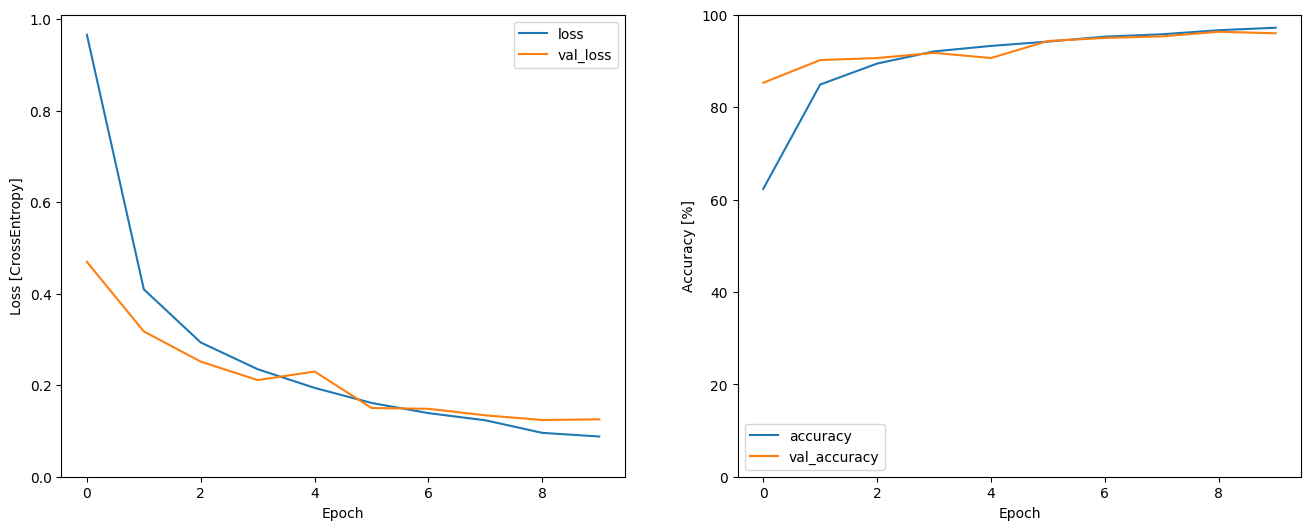

In [45]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [46]:
train_loss, train_accu = model.evaluate(train_spectrogram_ds)
val_loss, val_accu = model.evaluate(val_spectrogram_ds)
test_loss, test_accu = model.evaluate(test_spectrogram_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}, testing accuracy = {:.2f}".format(train_accu*100, val_accu*100, test_accu*100))

15/15 [==============================] - 1s 66ms/step - loss: 0.1750 - accuracy: 0.9449
final train accuracy = 98.23 , validation accuracy = 95.98, testing accuracy = 94.49


15/15 [==============================] - 1s 52ms/step


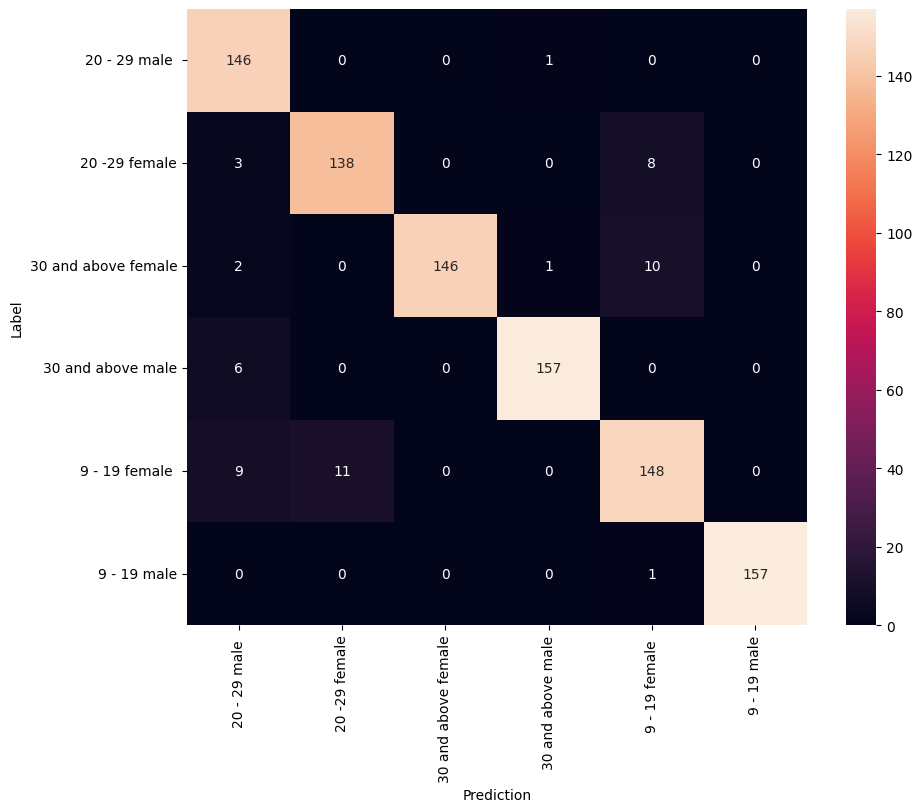

In [47]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [85]:
from sklearn.metrics import classification_report
import pprint
pprint.pprint(classification_report(y_true, y_pred, labels=[0,1,2,3,4,5]))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.88      0.99      0.93       147\n'
 '           1       0.93      0.93      0.93       149\n'
 '           2       1.00      0.92      0.96       159\n'
 '           3       0.99      0.96      0.98       163\n'
 '           4       0.89      0.88      0.88       168\n'
 '           5       1.00      0.99      1.00       158\n'
 '\n'
 '    accuracy                           0.94       944\n'
 '   macro avg       0.95      0.95      0.95       944\n'
 'weighted avg       0.95      0.94      0.95       944\n')


## From the cell above
* 0 represents '20 - 29 male'
* 1 represents '20 - 29 female'
* 2 represents '30 and above female'
* 3 represents '30 and aabove male'
* 4 represents '9 - 19 female'
* 5 represents '9 - 19 male'

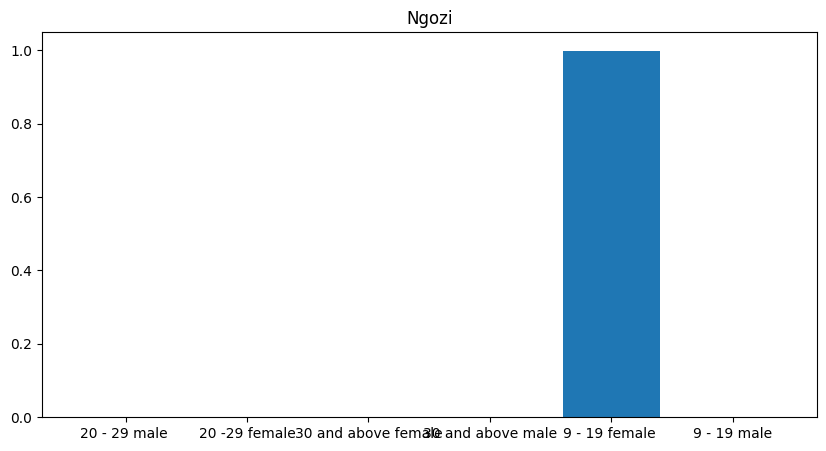

In [69]:
x = data_dir/'9 - 19 female /Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

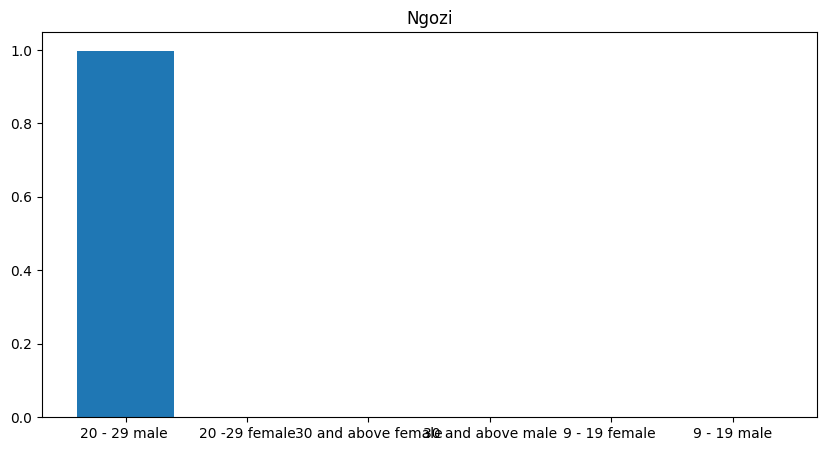

In [71]:
x = data_dir/'20 - 29 male /Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

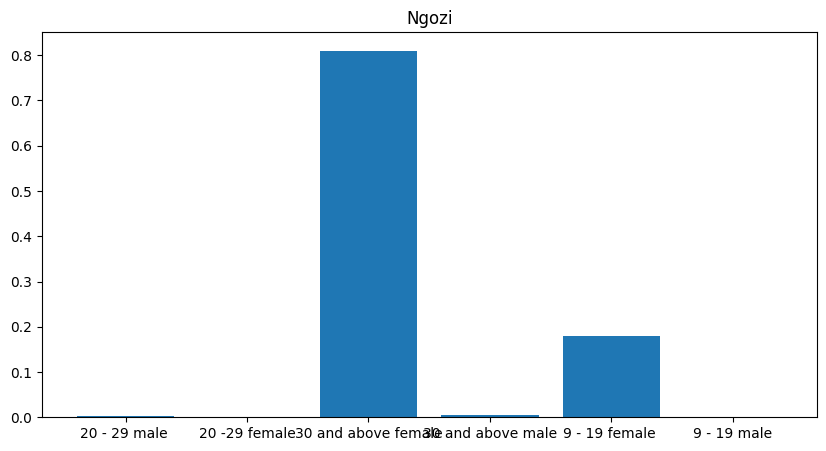

In [72]:
x = data_dir/'30 and above female/Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

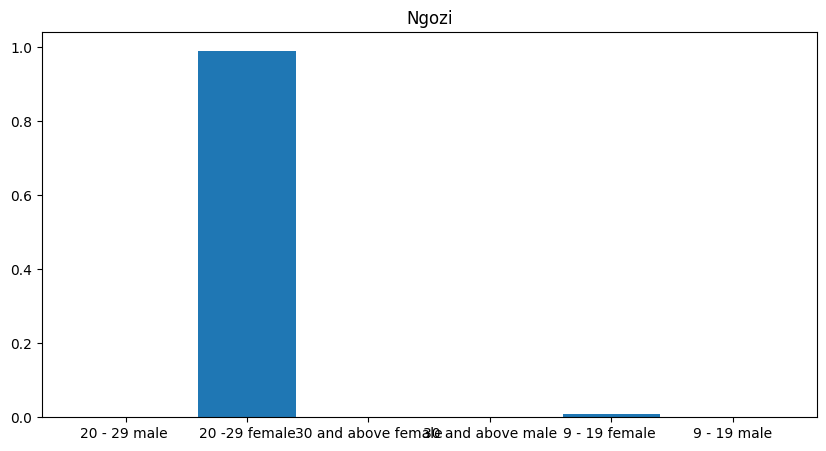

In [74]:
x = data_dir/'20 -29 female/Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

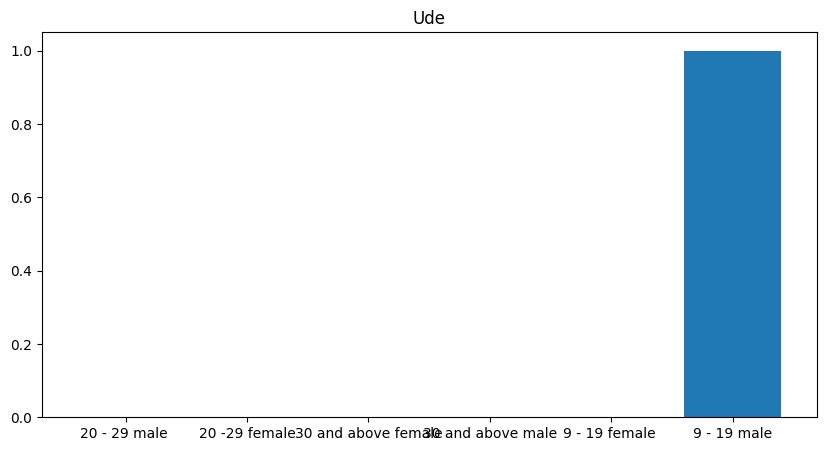

In [78]:
x = data_dir/'9 - 19 male/ude .wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ude')
plt.show()

display.display(display.Audio(waveform, rate=16000))

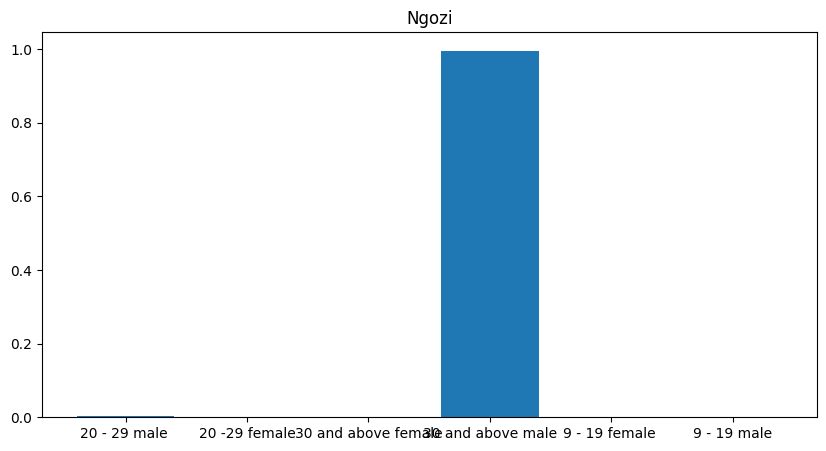

In [81]:
x = data_dir/'30 and above male/Ngozi.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ngozi')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [83]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Commands: ['30 and above male' '9 - 19 male' '20 -29 female' '9 - 19 female '
 '20 - 29 male ' '30 and above female']


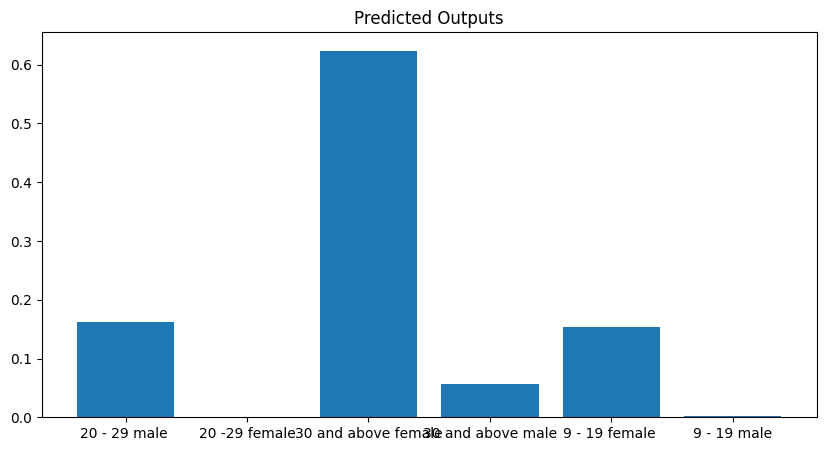

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 0.73372334, -4.1214776 ,  2.0774074 , -0.31669402,  0.6766079 ,
         -3.9813285 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'30 and above female'], dtype=object)>}

In [84]:

# *******************************************************************************************************************

#                                     PREDICTION OF NEW AUDIO FILE

# *******************************************************************************************************************


print('Commands:', commands)
predict = 'predict_audios/fortune2.wav'
x = predict
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
plt.figure(figsize=(10,5))

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicted Outputs')
plt.show()

export = ExportModel(model)
export(tf.constant(str(predict)))